In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

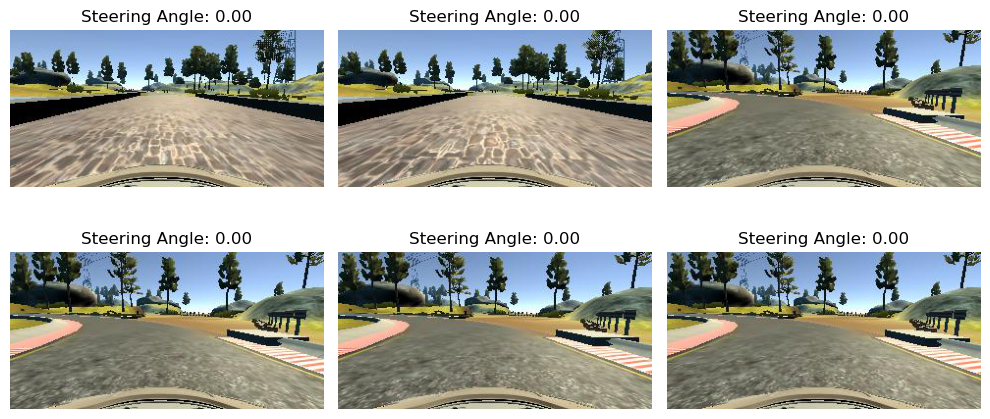

In [3]:
DATA_PATH = r"C:\Users\ahmed\Documents\Python Scripts\Self-driving car simulation (CNN)\dataset" 
DRIVING_LOG = os.path.join(DATA_PATH, "driving_log.csv")

# Load driving log
data = pd.read_csv(DRIVING_LOG)
data.head()

# Visualize some samples
plt.figure(figsize=(10, 5))
for i in range(6):
    img_path = os.path.join(DATA_PATH, data.iloc[i]['center'])
    img = load_img(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Steering Angle: {data.iloc[i]['steering']:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
def preprocess_image(img_path, target_size=(66, 200)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # Normalize
    return img

# Load and preprocess data
X = []
y = []

for i, row in data.iterrows():
    img_path = os.path.join(DATA_PATH, row['center'])
    X.append(preprocess_image(img_path))
    y.append(row['steering'])

X = np.array(X)
y = np.array(y)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 6428, Validation samples: 1608


In [5]:
def build_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(66, 200, 3)))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))  # Steering angle output
    return model

model = build_model()
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    shuffle=True
)

# Save the trained model
model.save("self_driving_car_model.h5")

Epoch 1/10
201/201 [==============================] - 86s 422ms/step - loss: 0.0126 - val_loss: 0.0102
Epoch 2/10
201/201 [==============================] - 86s 428ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 3/10
201/201 [==============================] - 84s 417ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 4/10
201/201 [==============================] - 82s 409ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 5/10
201/201 [==============================] - 86s 427ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 6/10
201/201 [==============================] - 86s 429ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 7/10
201/201 [==============================] - 98s 488ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 8/10
201/201 [==============================] - 94s 468ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 9/10
201/201 [==============================] - 89s 444ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 10/10
201/201 [==============================] - 86s 429ms/step - l

51/51 [==============================] - 2s 30ms/step
Mean Squared Error (MSE): 0.0087
Mean Absolute Error (MAE): 0.0566


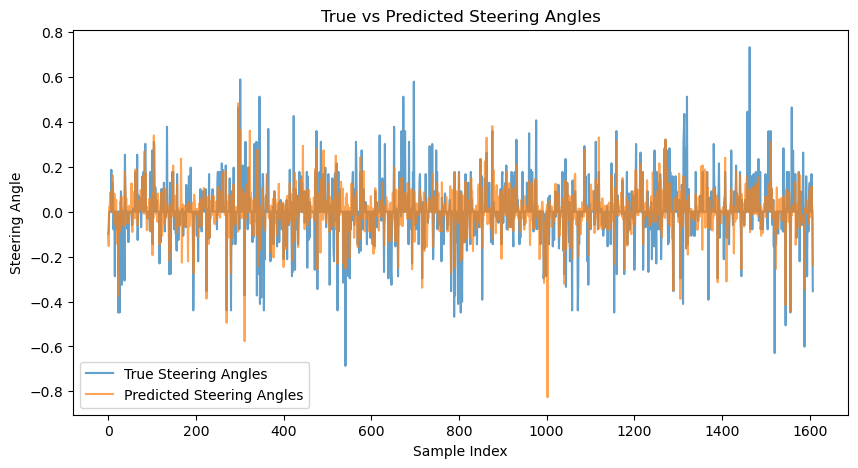

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the validation set
y_pred = model.predict(X_val).flatten()

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

# Display metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Visualize predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_val, label="True Steering Angles", alpha=0.7)
plt.plot(y_pred, label="Predicted Steering Angles", alpha=0.7)
plt.legend()
plt.title("True vs Predicted Steering Angles")
plt.xlabel("Sample Index")
plt.ylabel("Steering Angle")
plt.show()

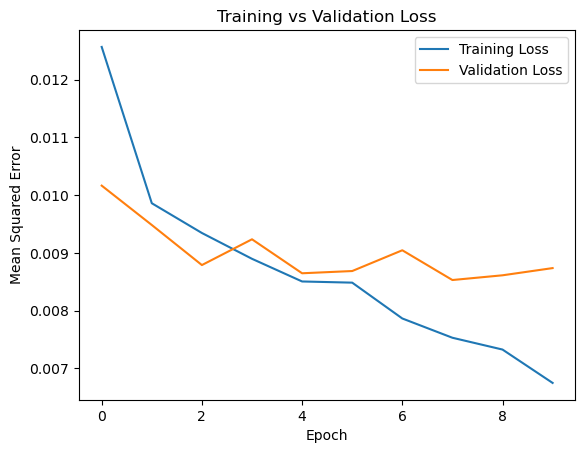

1/1 [==============================] - 0s 35ms/step
True Steering: 0.00, Predicted Steering: 0.01


In [8]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Test with a single image
sample_idx = 42
test_image = X_val[sample_idx]
true_steering = y_val[sample_idx]

predicted_steering = model.predict(test_image[np.newaxis, ...])[0][0]
print(f"True Steering: {true_steering:.2f}, Predicted Steering: {predicted_steering:.2f}")